## PreRequisites

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import re
import imutils
from imageStitching import *

## Image Stitching

In [6]:
inputPath = "./input/office/"
PanoCreator = ImageStitcher(inputPath)

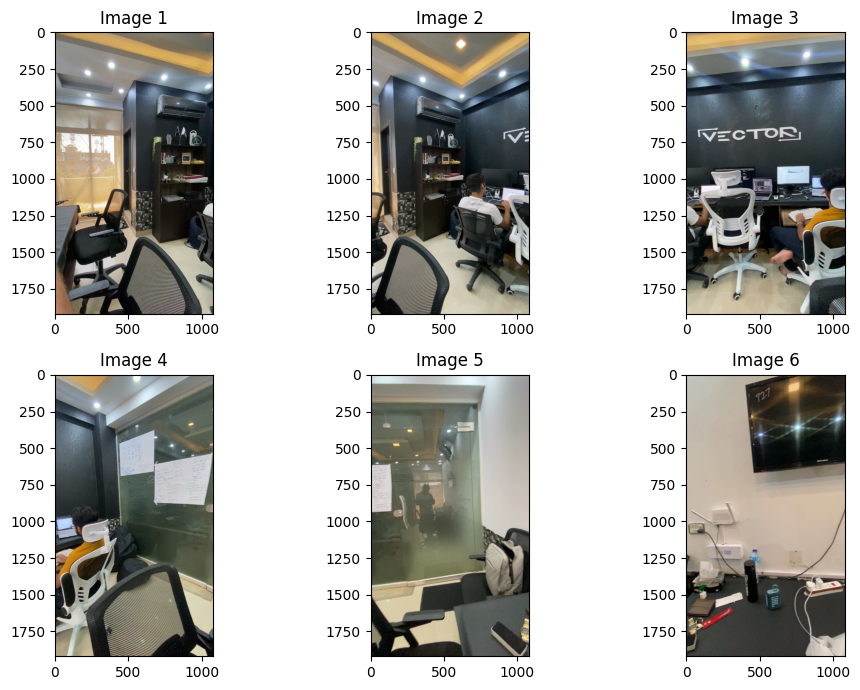

In [7]:
PanoCreator.display_Images()

In [8]:
Stitched = PanoCreator.stitch()

Success


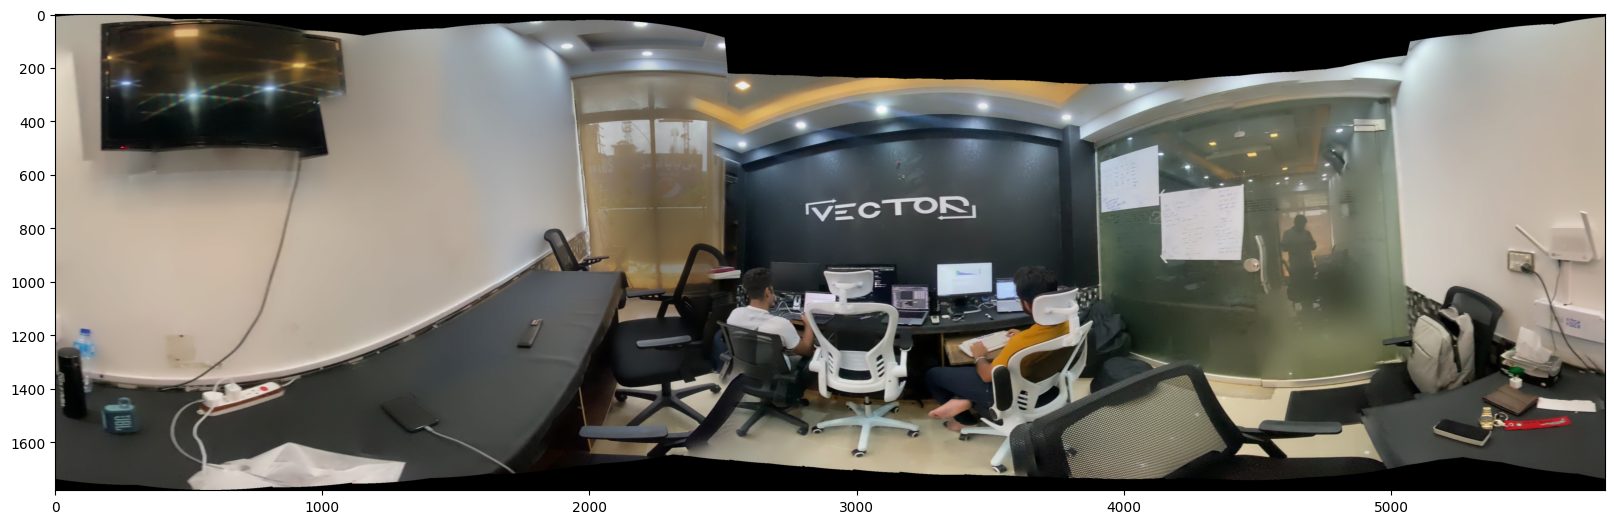

In [9]:
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(cv2.cvtColor(Stitched, cv2.COLOR_BGR2RGB))
plt.show()

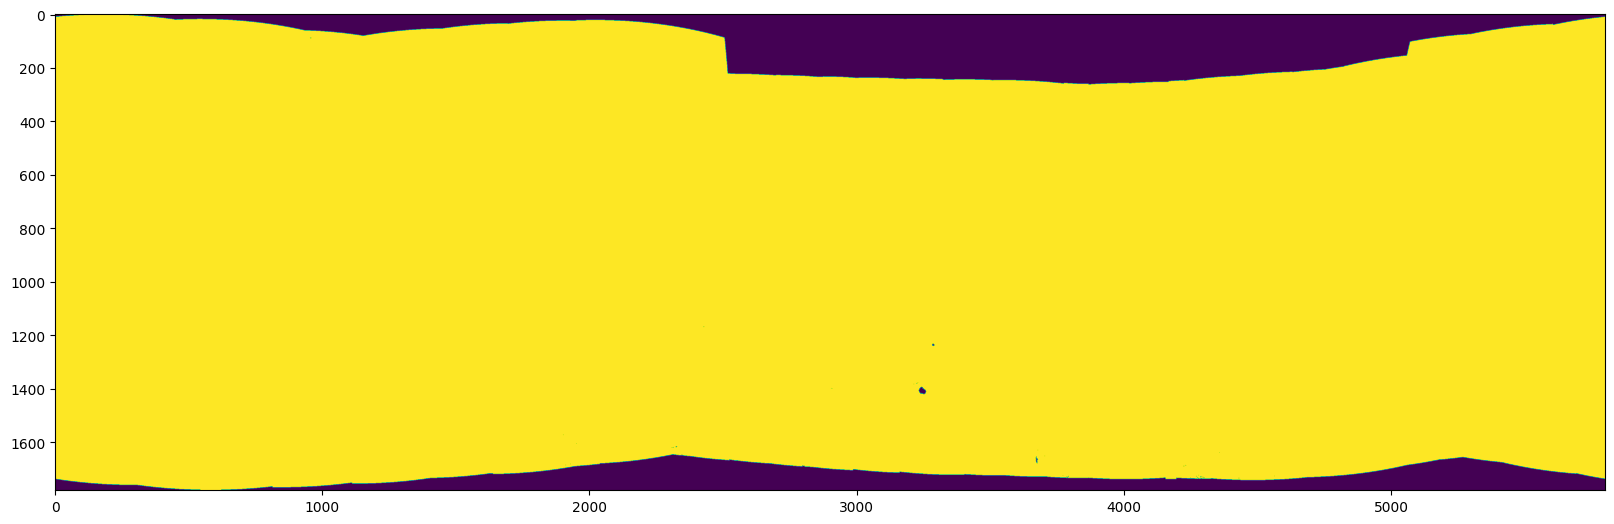

In [10]:
mask = PanoCreator.get_Pano_Mask()

plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(mask)
plt.show()

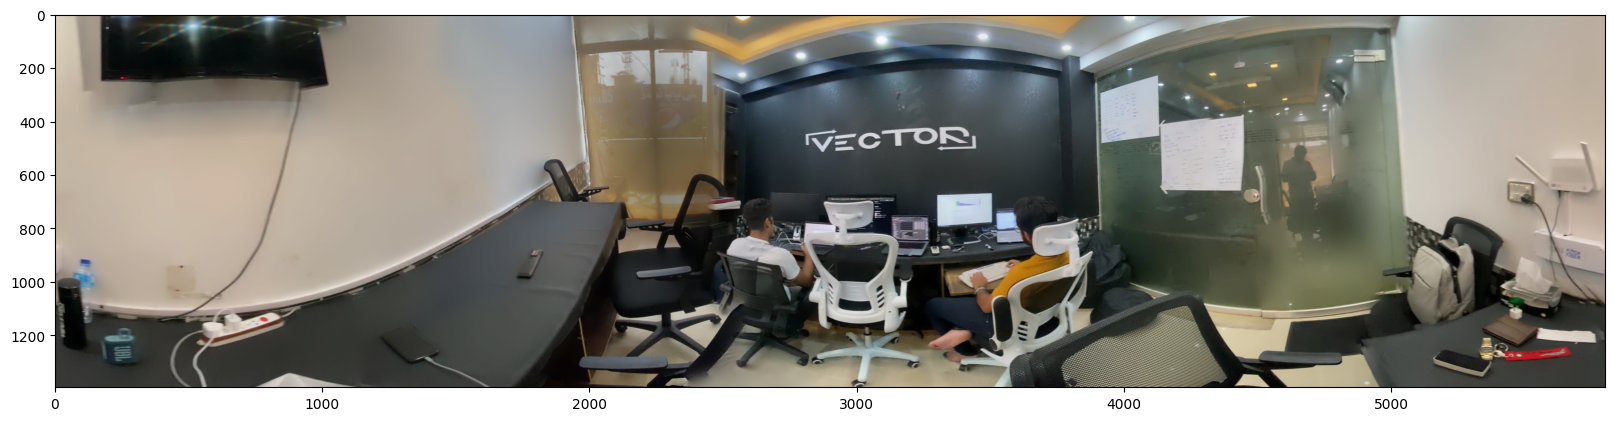

In [11]:
CroppedRec = PanoCreator.crop_to_rectangle()
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(CroppedRec)
plt.show()

In [12]:
# save image
outPath = "./output/office.jpg"
cv2.imwrite(outPath,cv2.cvtColor(CroppedRec, cv2.COLOR_BGR2RGB))

True

________

## Information Extraction Feature 

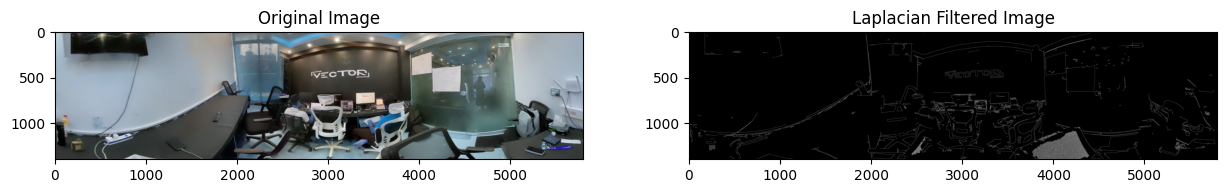

In [13]:
#Loading the image and removing noise through thresholding
image_original = cv2.imread(outPath, cv2.IMREAD_COLOR)
image_gray = cv2.cvtColor(image_original, cv2.COLOR_BGR2GRAY)
filtered_image = cv2.Canny(image_gray, threshold1=20, threshold2=200)

#Plotting the image and corresponding Laplacian Edge Detector
(fig, (ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 15))
ax1.title.set_text('Original Image')
ax1.imshow(image_original)
ax2.title.set_text('Laplacian Filtered Image')
ax2.imshow(filtered_image, cmap='gray')

/var/folders/jw/lz3gc5915cxgsvv61ql8_83c0000gn/T/ipykernel_89466/3159487981.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = int((image.shape[0] - intercept) / slope)
/var/folders/jw/lz3gc5915cxgsvv61ql8_83c0000gn/T/ipykernel_89466/3159487981.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = int((-intercept) / slope)


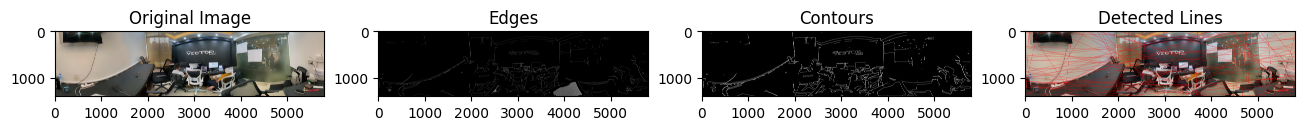

In [14]:
def find_wall_edges(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and help edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Canny edge detector
    edges = cv2.Canny(blurred, 50, 150)

    # Apply morphological operations to close gaps in contours
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Find contours in the closed image
    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on a black background
    contour_image = np.zeros_like(image)
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 2)

    # Fit lines to the contours
    lines_image = image.copy()
    for contour in contours:
        if len(contour) > 50:  # Filter out small contours
            vx, vy, x, y = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)
            slope = vy / vx
            intercept = y - slope * x
            x1 = int((image.shape[0] - intercept) / slope)
            x2 = int((-intercept) / slope)
            cv2.line(lines_image, (x1, image.shape[0]), (x2, 0), (0, 0, 255), 2)

    # Display the original image, edges, contours, and detected lines using matplotlib
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(edges, cmap='gray')
    plt.title('Edges')

    plt.subplot(1, 4, 3)
    plt.imshow(contour_image, cmap='gray')
    plt.title('Contours')

    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(lines_image, cv2.COLOR_BGR2RGB))
    plt.title('Detected Lines')

    plt.show()

# Replace 'your_panorama_image.jpg' with the path to your panorama image
find_wall_edges(outPath)


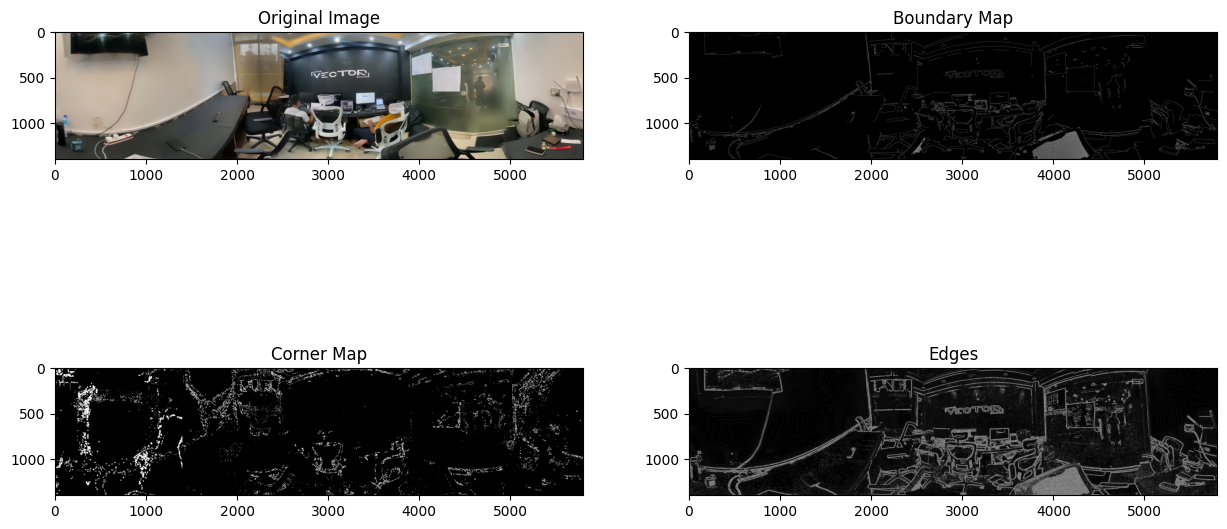

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_boundary_and_corners(image_path):
    # Read the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Converting the image to an HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    #Setting up a color range for walls
    lower_wall_color = np.array([20, 0, 50])
    upper_wall_color = np.array([40, 255, 255])

    #Creating a binary mask for the wall color
    wall_mask = cv2.inRange(hsv, lower_wall_color, upper_wall_color)
    segmented_image = cv2.bitwise_and(image, image, mask=wall_mask)

    #1) Applying a Gaussian Blurring Filter to reduce noise and assist edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    #2) Using Canny Filter for Boundary Detection
    boundary = cv2.Canny(blurred, 30, 100)

    #3) Using a Harris corner detection to the segmented image
    gray_segmented = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
    corners = cv2.cornerHarris(gray_segmented, blockSize=2, ksize=3, k=0.04)

    corners = cv2.dilate(corners, None)
    corner_map = np.zeros_like(gray_segmented)
    corner_map[corners > 0.01 * corners.max()] = 255

    #Finding coordinates of corners
    corner_coords = np.column_stack(np.where(corners > 0.01 * corners.max()))
    for x, y in corner_coords:
        cv2.circle(corner_map, (x, y), 3, 255, -1)

    #4) Using the Laplacian of Gaussian function for edge detection
    edges = cv2.Laplacian(blurred, cv2.CV_64F, ksize=5)
    edges = np.uint8(np.absolute(edges))

    plt.figure(figsize=(15, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    plt.subplot(2, 2, 2)
    plt.imshow(boundary, cmap='gray')
    plt.title('Boundary Map')

    plt.subplot(2, 2, 3)
    plt.imshow(corner_map, cmap='gray')
    plt.title('Corner Map')

    plt.subplot(2, 2, 4)
    plt.imshow(edges, cmap='gray')
    plt.title('Edges')
    
    plt.show()

extract_boundary_and_corners(outPath)

## Object Detection

In [18]:
!yolo predict model=yolov8x-seg.pt source='./output/office.jpg' show_conf=False

Ultralytics YOLOv8.0.200 🚀 Python-3.10.13 torch-2.0.1 CPU (Apple M1 Pro)
YOLOv8x-seg summary (fused): 295 layers, 71797696 parameters, 0 gradients, 344.1 GFLOPs

image 1/1 /Users/abdulwadood/Documents/FYP/Code/Final/output/office.jpg: 160x640 3 persons, 6 chairs, 2 tvs, 2 remotes, 1 keyboard, 1 book, 221.4ms
Speed: 3.0ms preprocess, 221.4ms inference, 3.8ms postprocess per image at shape (1, 3, 160, 640)
Results saved to runs/segment/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


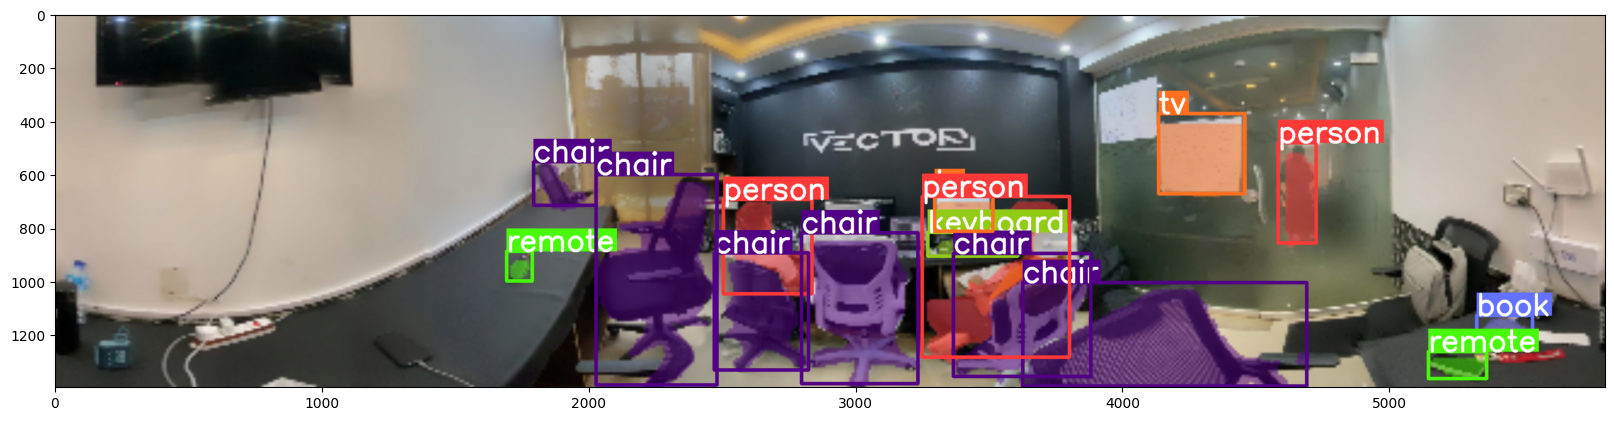

In [30]:
resultPath = "./runs/segment/"
detectedObjPath = "./runs/segment/" + sorted(os.listdir("./runs/segment/"))[-1] + "/" + outPath.split('/')[-1]

detectedObj = cv2.imread(detectedObjPath)
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(cv2.cvtColor(detectedObj, cv2.COLOR_BGR2RGB))
plt.show()
# detectedObj

______

### Depth estimation using MiDaS 

In [5]:
# !python MiDaS/run.py --input_path ../output/office.jpg --output_path ../output

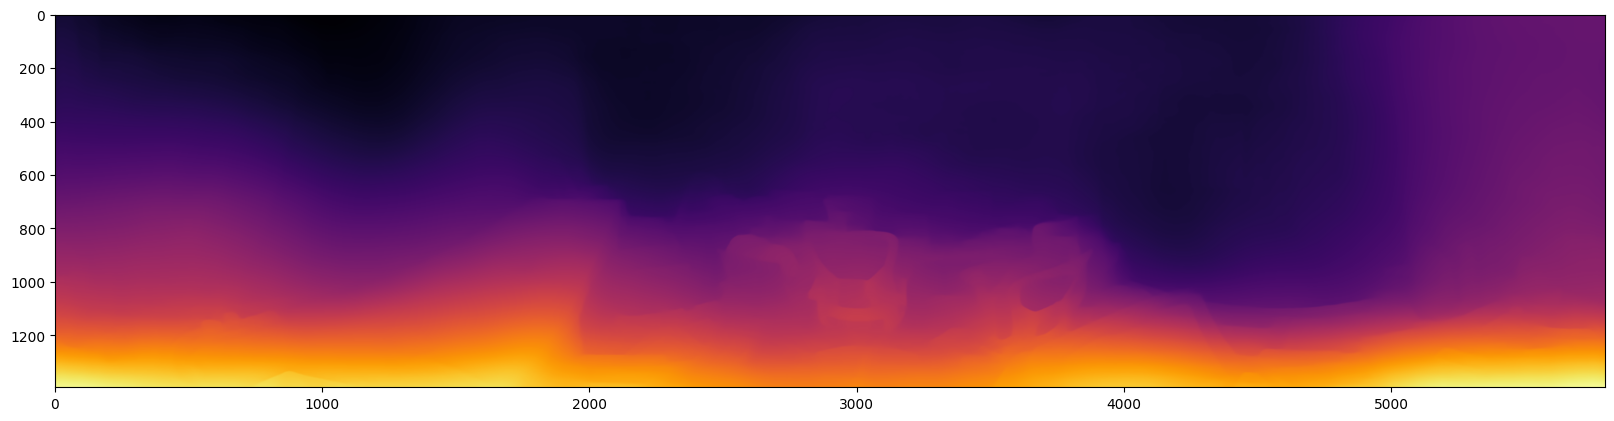

In [20]:
plt.imshow(cv2.cvtColor(cv2.imread("./output/office-dpt_beit_large_512.png"), cv2.COLOR_BGR2RGB))
plt.show()

### Room layout generation
Commands

In [21]:
# python3 preprocess.py --img_glob assets/demo.png --output_dir assets/preprocessed/
# python3 inference.py --pth ckpt/resnet50_rnn__mp3d.pth --img_glob assets/preprocessed/demo_aligned_rgb.png --output_dir assets/inferenced --visualize
# python3 layout_viewer.py --img assets/preprocessed/demo_aligned_rgb.png --layout assets/inferenced/demo_aligned_rgb.json --ignore_ceiling


In [22]:
# python3 preprocess.py --img_glob ../office.jpg --output_dir assets/prepOffice/
# python3 inference.py --pth ../resnet50_rnn__panos2d3d.pth --img_glob assets/prepOffice/office_aligned_rgb.png --output_dir assets/inferOffice --visualize --no_cuda
# python3 layout_viewer.py --img assets/prepOffice/office_aligned_rgb.png --layout assets/inferOffice/office_aligned_rgb.json --ignore_ceiling --vis

In [23]:
# python3 preprocess.py --img_glob ../1.jpg --output_dir assets/prep1/
# python3 inference.py --pth ../resnet50_rnn__panos2d3d.pth --img_glob assets/prep1/1_aligned_rgb.png --output_dir assets/infer1 --visualize --no_cuda
# python3 layout_viewer.py --img assets/prep1/1_aligned_rgb.png --layout assets/infer1/1_aligned_rgb.json --ignore_ceiling --vis

In [24]:
# python3 preprocess.py --img_glob ../room_Pano.jpg --output_dir assets/preproom_Pano/
# python3 inference.py --pth ../resnet50_rnn__panos2d3d.pth --img_glob assets/preproom_Pano/room_Pano_aligned_rgb.png --output_dir assets/inferroom_Pano --visualize --no_cuda
# python3 layout_viewer.py --img assets/preproom_Pano/room_Pano_aligned_rgb.png --layout assets/inferroom_Pano/room_Pano_aligned_rgb.json --ignore_ceiling --vis

________